<h2>Calculation of Well Head Protection Area</h2>

This Notebook is computes well function and the radious of the buffer required for well Head Protection

Write a  function for W(u) using the equiation
1. Assume a list or radii(r)
2. Substiutute Values for Q,T,t,S
3. Solve for drawdown as a fuction of radius
4. Select radius corresponding to critical drawdown
5. Plot the buffer and visualize
   

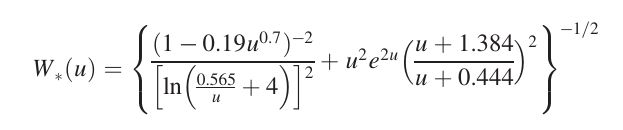

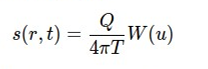

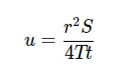

T = Transmissivility (sq.ft/day); t= time(days), S = Storage Coefficient; s = drawdown(ft), r= distance from well (ft)

In [131]:
!pip install matplotlib-scalebar

In [132]:
#Import Libraries
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import geopandas as gpd
import matplotlib_map_utils as mu #To draw north arroww
from matplotlib_scalebar.scalebar import ScaleBar # To draw scalebar

<h2> Set Working Directory

In [133]:
path = 'C:/Users/Sushant/OneDrive - Lamar University/1st semester/GIS/Inclass assignment/2nd/TX_Waterwell'
os.chdir(path)

<h4>Python function for Theis function

In [134]:
# function to compute W(u) from u
import numpy as np
def Wu(u):
    num1 = (1-0.19*u**0.7)**(-2)
    num2 = (np.log(0.565/u + 4 ))**2
    num3 = np.power(u,2) * np.exp(2*u)
    num4 = ((u+1.384)/(u+0.444))**2
    wu = ((num1/num2) + num3*num4)**(-0.5)
    return(wu)

In [135]:
#Test an example
u = 0.1
wu = Wu(u)
wu

1.8223542901440897

In [136]:
fname = 'PWells_GAM.gpkg'
Tval = gpd.read_file(fname)
Pop = 20000
pcu = 135 #gallons/d/capita
tyears = 10 #10 yeas design time
S = 0.005 # Assume base on litarature 
T = list(Tval.T_SQFTDay)#T values in sqft & days
T


[3358, 3352, 3190, 3336, 3315, 3247, 2850, 2902, 3032]

In [137]:
# All values in units of fit for length and days for time
Q = Pop*pcu*0.133681 #Pumping cubic feet per day
t = tyears*365.25 # time in days
r = np.arange(1,300001,1)

In [143]:
Tx = T[8]
u = r**2*S/(4*Tx*t)
W = Wu(u)
s = Q/(4*np.pi*Tx)*W
s

C:\Users\Sushant\AppData\Local\ipykernel_3148\3737756486.py:4: RuntimeWarning: invalid value encountered in power
  num1 = (1-0.19*u**0.7)**(-2)
C:\Users\Sushant\AppData\Local\ipykernel_3148\3737756486.py:5: RuntimeWarning: divide by zero encountered in divide
  num2 = (np.log(0.565/u + 4 ))**2
C:\Users\Sushant\AppData\Local\ipykernel_3148\3737756486.py:5: RuntimeWarning: invalid value encountered in log
  num2 = (np.log(0.565/u + 4 ))**2
C:\Users\Sushant\AppData\Local\ipykernel_3148\3737756486.py:8: RuntimeWarning: divide by zero encountered in power
  wu = ((num1/num2) + num3*num4)**(-0.5)


array([198.16848862, 185.90548215, 178.73207988, ...,          nan,
                nan,          nan])

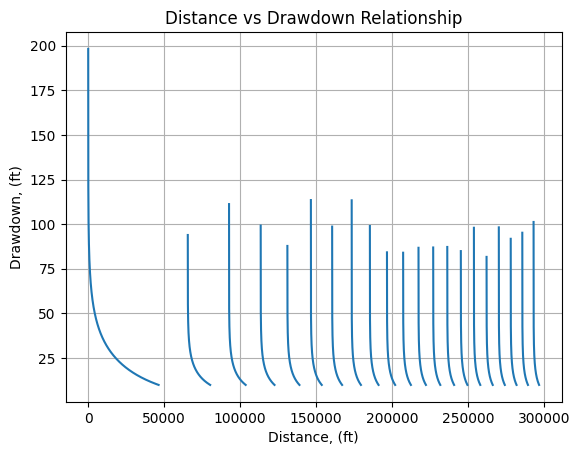

In [144]:
# Make plot
plt.plot(r, s)
plt.xlabel('Distance, (ft)')  # Corrected xlabel
plt.ylabel('Drawdown, (ft)')  # Corrected ylabel
plt.title('Distance vs Drawdown Relationship')
plt.grid()
plt.show()


In [154]:
ra = np.array(r)
np.interp(-10,-s,r)*0.000189394 #Convert Ft to miles; s values in increasing order


nan

In [173]:
#Loop and find the values 
scrit = []
sc = -17 # Acceptable Drawdown
rx = np.array(r)
for Tx in T:
    u = r**2*S/(4*Tx*t)
    W = Wu(u)
    s = Q/(4*np.pi*Tx)*W
    rwhx = np.interp(sc,-s,rx) * 0.000189394# The interpolation requires x to be in increasing order (this negetive va
    scrit.append(round(rwhx,2))
print(scrit)


C:\Users\Sushant\AppData\Local\ipykernel_3148\3737756486.py:4: RuntimeWarning: invalid value encountered in power
  num1 = (1-0.19*u**0.7)**(-2)
C:\Users\Sushant\AppData\Local\ipykernel_3148\3737756486.py:5: RuntimeWarning: divide by zero encountered in divide
  num2 = (np.log(0.565/u + 4 ))**2
C:\Users\Sushant\AppData\Local\ipykernel_3148\3737756486.py:5: RuntimeWarning: invalid value encountered in log
  num2 = (np.log(0.565/u + 4 ))**2
C:\Users\Sushant\AppData\Local\ipykernel_3148\3737756486.py:8: RuntimeWarning: divide by zero encountered in power
  wu = ((num1/num2) + num3*num4)**(-0.5)


[5.42, 5.43, 5.58, 5.44, 5.46, 5.52, 5.89, 5.85, 5.72]


In [174]:
# Make Buffer Around Each point
Tvalaea = Tval.to_crs('EPSG:6350')  # Convert the point object to EPSG:6350 (Albers Equal Area)
scritm = list(x * 1609.34 for x in scrit)  # Convert miles to meters so the buffer lengths are consistent
buffpts = Tvalaea.geometry.buffer(scritm)  # Apply buffer to each well
buffgdf = gpd.GeoDataFrame(geometry=buffpts)  # Create a GeoDataFrame of buffers


In [175]:
# Plot Buffers and Overlay them on Jefferson County Map
xl, xu, yl, yu = buffgdf.total_bounds  # Get bounds for plotting
fname2 = 'JeffersonWGS84.gpkg'
Jefferson = gpd.read_file(fname2)
Jeffaea = Jefferson.to_crs('EPSG:6350')

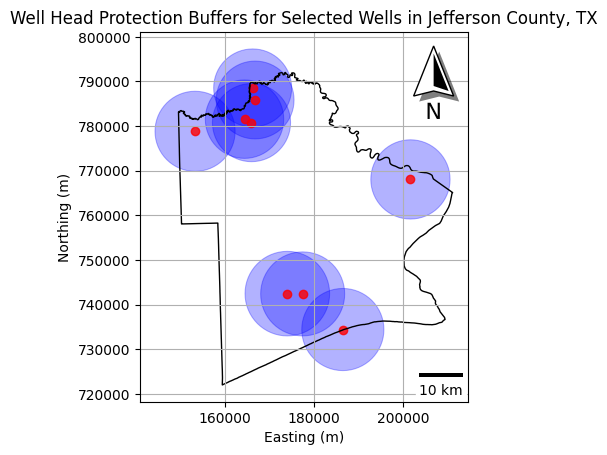

In [184]:
fig, ax = plt.subplots()
buffgdf.plot(ax=ax, figsize=(10, 10), color='blue', edgecolor='blue', alpha=0.3, linewidth=0.75)
Tvalaea.plot(ax=ax, facecolor='red', edgecolor='red', alpha=0.8)
Jeffaea.plot(ax=ax, facecolor='none', edgecolor='black')

mu.north_arrow.north_arrow(ax=ax, location='upper right', rotation={"degrees": 0})
scalebar = ScaleBar(1, units="m", location="lower right", length_fraction=0.2)
ax.add_artist(scalebar)

ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.title('Well Head Protection Buffers for Selected Wells in Jefferson County, TX')
plt.grid()
plt.show()

In [191]:
buffgdf['Areasqmi'] = buffgdf.area/(2589988.11)
print(buffgdf['Areasqmi'])
buffgdf.head()


0     92.140045
1     92.480359
2     97.660343
3     92.821300
4     93.505064
5     95.571412
6    108.812913
7    107.339997
8    102.622338
Name: Areasqmi, dtype: float64


,geometry,Areasqmi
0,"POLYGON ((175557.47 785849.276, 175515.468 784...",92.140045
1,"POLYGON ((175016.51 788553.163, 174974.43 7876...",92.480359
2,"POLYGON ((162352.262 778829.428, 162309.02 777...",97.660343
3,"POLYGON ((174772.9 780777.008, 174730.744 7799...",92.821300
4,"POLYGON ((173239.69 781550.465, 173197.378 780...",93.505064


In [187]:
buffdiss = buffgdf.dissolve()

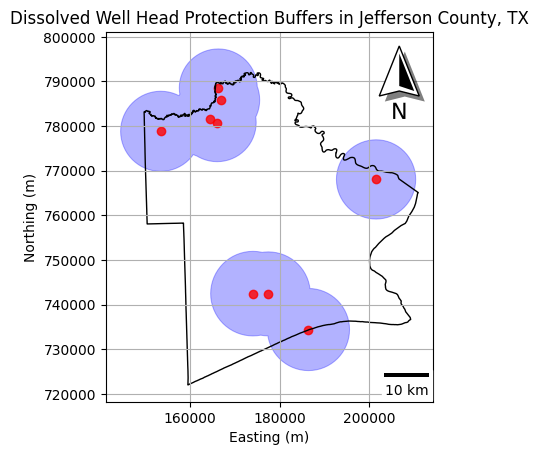

In [179]:
fig, ax = plt.subplots()
buffdiss.plot(ax=ax, figsize=(10, 10), color='blue', edgecolor='blue', alpha=0.3, linewidth=0.75)
Tvalaea.plot(ax=ax, facecolor='red', edgecolor='red', alpha=0.8)
Jeffaea.plot(ax=ax, facecolor='none', edgecolor='black')

mu.north_arrow.north_arrow(ax=ax, location='upper right', rotation={"degrees": 0})
scalebar = ScaleBar(1, units="m", location="lower right", length_fraction=0.2)
ax.add_artist(scalebar)

ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.title('Dissolved Well Head Protection Buffers in Jefferson County, TX')
plt.grid()
plt.show()
